# Visualizing Neural Networks using t-SNE


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from birdclassification.preprocessing.spectrogram import generate_mel_spectrogram_seq

torch.manual_seed(42)
np.random.seed(42)

## Model

In [2]:
from torch import nn


class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / liniear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear1  = nn.Sequential(
            nn.Linear(
            10880, 1024
            ),
            nn.ReLU()
        )
        self.linear2 = nn.Linear(
            1024, 30
        )

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.linear1(x)
        logits = self.linear2(x)
        return logits



In [3]:
PATH = 'model_20231209_132114_3'
cnn = CNNNetwork()
cnn.load_state_dict(torch.load(PATH))
cnn.eval()

CNNNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Sequential(
    (0): Linear(in_features=10880, out_features=1024, bias=True)
    (1): ReLU()
  )
  (linear2): Linear(in_f

## Dataset

In [4]:
from birdclassification.preprocessing.filtering import filter_recordings_30
from sklearn.model_selection import train_test_split
from birdclassification.training.dataset import Recordings30

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 123
#RECORDINGS_DIR = '/mnt/d/recordings_30/'
RECORDINGS_DIR = '/media/jacek/E753-A120/recordings_30/'
NOISES_DIR = '/path/to/noise/dataset'
SAMPLE_RATE = 32000
NUM_SAMPLES = SAMPLE_RATE * 1
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
EPOCHS = 5
NUM_WORKERS = 8
df = filter_recordings_30("../data/xeno_canto_recordings.csv", "../data/bird-list-extended.csv", )

train_df, test_val_df = train_test_split(df, stratify=df['Latin name'], test_size=0.2, random_state=SEED)
val_df, test_df = train_test_split(test_val_df, stratify=test_val_df['Latin name'], test_size=0.5, random_state=SEED)

train_ds = Recordings30(train_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR, sample_rate=SAMPLE_RATE,
                        device=DEVICE)
val_ds = Recordings30(val_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR, sample_rate=32000, device=DEVICE)
test_ds = Recordings30(test_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR, sample_rate=32000, device=DEVICE)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

/home/jacek/Documents/PycharmProjects/Bird-classification-model/birdclassification/preprocessing/filtering.py:72: DtypeWarning: Columns (10,39,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  recordings = pd.read_csv(filepath_recordings)


In [5]:
len(train_ds)

32967

In [6]:
img = []
label = []
for i in range(len(test_ds)):
    if i%100 == 0:
        print(i)
    waveform, l = test_ds[i]
    spectrogram = generate_mel_spectrogram_seq(y=waveform.to(DEVICE), sr=32000, n_fft=512, hop_length=384, device=DEVICE)
    spectrogram = spectrogram
    img.append(spectrogram.to("cpu").numpy())
    label.append(l)

img = np.asarray(img)
label = np.asarray(label, dtype = np.int8)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100


## Embedding (skipping last layer of the model)

In [7]:
def embedding_fc2(input_data):
    input_data = torch.Tensor(input_data).float()
    cnn.eval()
    x = cnn.conv1(input_data)
    x = cnn.conv2(x)
    x = cnn.conv3(x)
    x = cnn.conv4(x)
    x = cnn.flatten(x)
    x = cnn.linear1(x)
    return x

## Color palette 

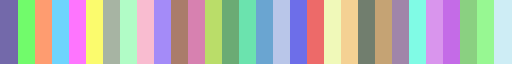

In [8]:
import distinctipy
import itertools

N = 30
colors = distinctipy.get_colors(N, pastel_factor=0.7)
tab30_c = distinctipy.get_colormap(colors)
tab30_c

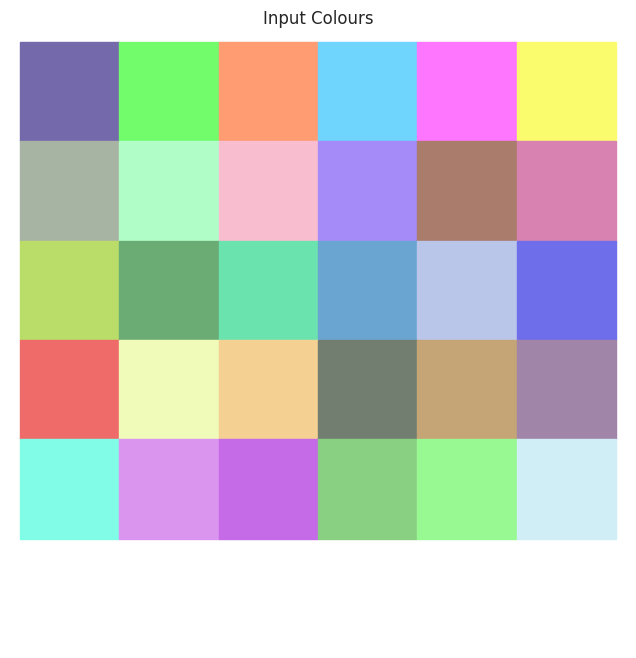

In [9]:
distinctipy.color_swatch(colors, title="Input Colours")

## t-SNE

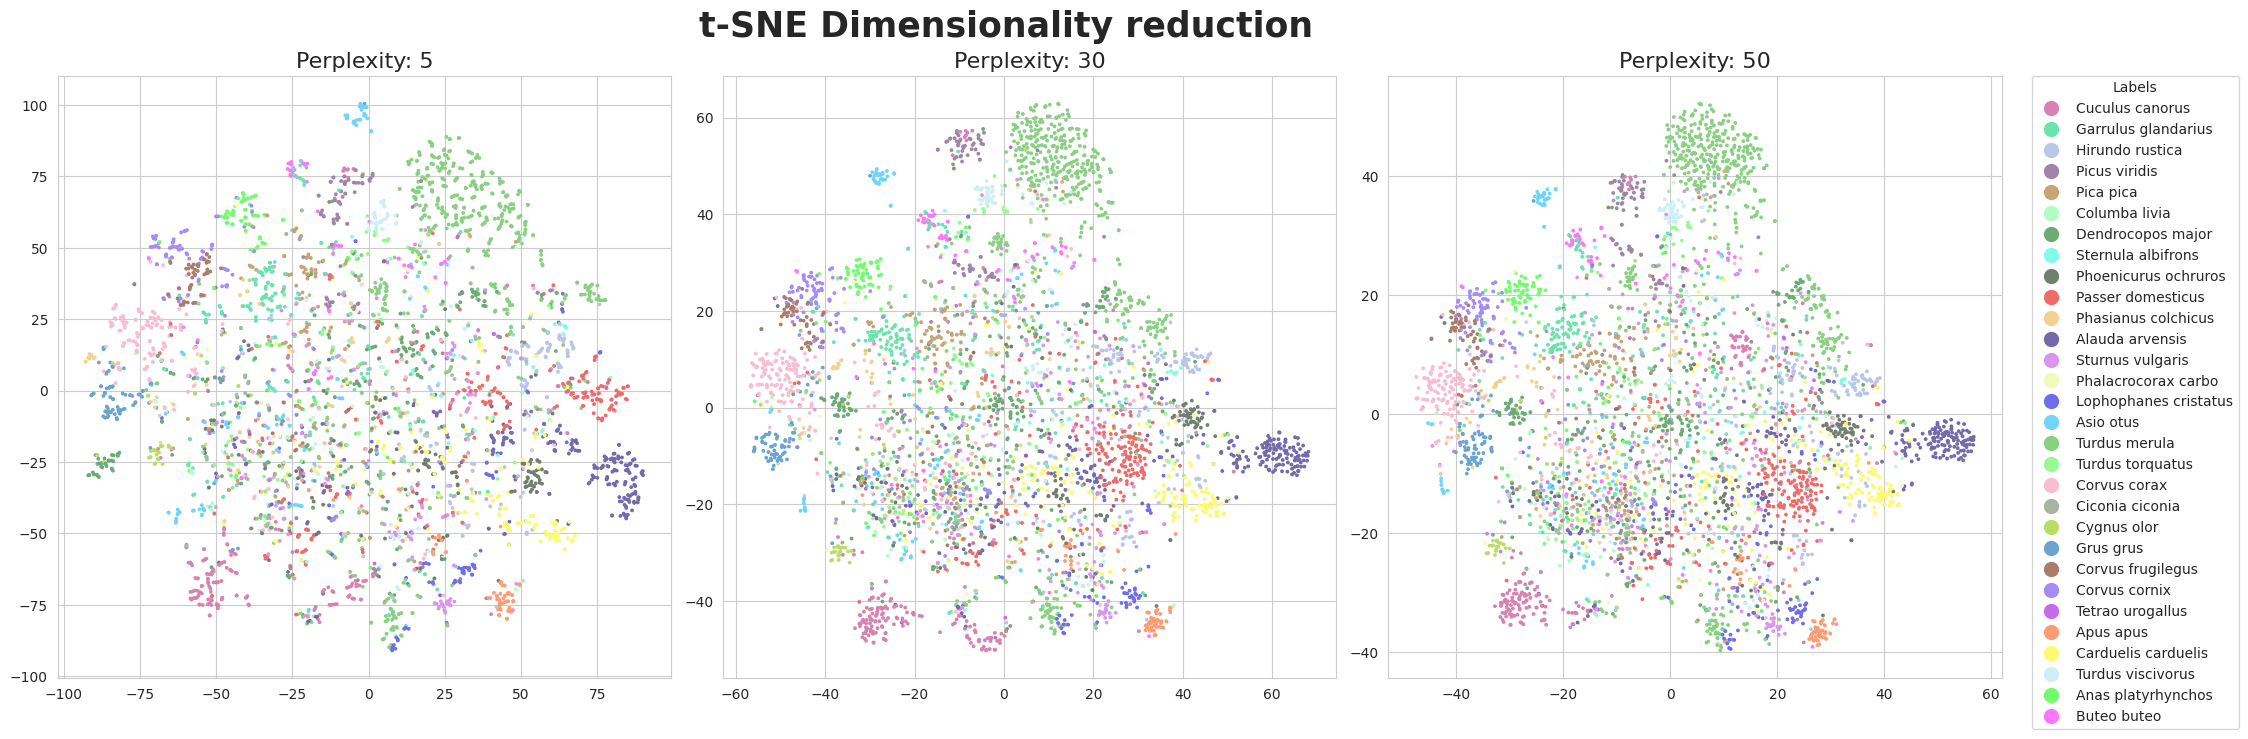

In [10]:
from sklearn.manifold import TSNE
fig, ax = plt.subplots(1, 3, figsize=(20,7), constrained_layout=True)

embedding = embedding_fc2(img)

for c, per in zip(itertools.count(), [5, 30, 50]):
    tsne = TSNE(n_components=2,
                perplexity=per,
                n_iter =  1000)
    
    tsne = tsne.fit_transform(embedding.detach().numpy())
    scatter = ax[c].scatter(tsne[:, 0], tsne[:, 1], c=label, s=3.0, cmap = tab30_c, vmin=0, vmax = 29)
    ax[c].set_title(f'Perplexity: {per}', fontsize=16)
    
    mapping = train_ds.get_mapping()
    bird_names = [mapping[i] for i in  label]
    unique_names= list(set(zip(bird_names, label)))
    
    if c == 2: 
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=tab30_c(i), markersize=12, label=name)
                   for name, i in unique_names]
        fig.legend(handles=handles, title='Labels', bbox_to_anchor=(1.12, 0.91), loc='upper right')
    
        ax[c].set_title(f'Perplexity: {per}', fontsize=16)
        
visualziationfig.suptitle('t-SNE Dimensionality reduction', fontweight='bold', fontsize=25)
plt.show()

In [11]:
plt.savefig('tsne.svg')

<Figure size 640x480 with 0 Axes>